In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve

In [2]:
# 定义网格单元结构体
class GridCell:
    def __init__(self):
        self.id = 0 # 网格单元编号
        self.parent_id = 0 # 父单元编号
        self.child_id = [0,0,0,0] # 四个子单元编号，若无子单元则为0
        self.xmin = 0.0 # 单元格的左边界
        self.xmax = 0.0 # 单元格的右边界
        self.ymin = 0.0 # 单元格的下边界
        self.ymax = 0.0 # 单元格的上边界
        self.leaf_id = 0 # 叶子单元编号，若不是叶子单元则为0
        self.lev = 0 #单元的层数编号

In [3]:
# 定义构建网格的函数
def construct_grid(grid, leaf_id, parent_id, xmin, xmax, ymin,ymax):
    cell = GridCell() # 构建网格单元
    cell.id = len(grid) + 1 # 网格单元编号
    cell.parent_id = parent_id # 父单元编号
    cell.xmin = xmin # 单元格左边界
    cell.xmax = xmax # 单元格右边界
    cell.ymin = ymin # 单元格的下边界
    cell.ymax = ymax # 单元格的上边界
    cell.leaf_id = leaf_id # 叶子单元编号
    # 新单元格无子单元
    cell.child_id[0] = 0
    cell.child_id[1] = 0
    cell.child_id[2] = 0
    cell.child_id[3] = 0
    if parent_id == 0:
        cell.lev = 1
    else:
        cell.lev = grid[parent_id-1].lev+1 # 单元格层数
    grid.append(cell) # 将新的元素加到list的最后面，位置为当前最后一个元素的下一个元素

In [4]:
# 定义细化网格的函数
def refinement_grid(Lid, grid, leaf_id, parent_id, xmin, xmax, ymin, ymax, rand_idx):
    if grid[rand_idx].leaf_id != 0:
        grid[rand_idx].leaf_id = 0
    
    coordinates = [
        (xmin, (xmax+xmin) / 2.0, (ymax+ymin) / 2.0, ymax),
        ((xmax+xmin) / 2.0, xmax, (ymax+ymin) / 2.0, ymax),
        (xmin, (xmax+xmin) / 2.0, ymin, (ymax+ymin) / 2.0),
        ((xmax+xmin) / 2.0, xmax, ymin, (ymax+ymin) / 2.0)
    ]
    
    for coord in coordinates:
        leaf_id += 1
        construct_grid(grid, leaf_id, parent_id, *coord)
        Lid.append(grid[-1].id)
    
    grid[rand_idx].child_id[0] = len(grid)
    grid[rand_idx].child_id[1] = len(grid)
    grid[rand_idx].child_id[2] = len(grid)
    grid[rand_idx].child_id[3] = len(grid)

In [5]:
# 定义产生随机数的函数
def generate_random_int(Lid):
    return random.choice(Lid)

In [6]:
# 定义随机加密网格函数
def random_refinement_grid(Lid, grid, leaf_id, plen):
    if len(grid) < 32: # 网格细化条件
        # 随机选择一个叶子单元进行加密
        rand_idx = generate_random_int(Lid)
        #print(rand_idx)
        parent_id = grid[rand_idx-1].id
        plen.append(parent_id)

        # 输出加密网格的网格编号
        print("parent_id = ",parent_id)

        # 对选中的网格单元进行加密
        xmin = grid[rand_idx-1].xmin
        xmax = grid[rand_idx-1].xmax
        ymin = grid[rand_idx-1].ymin
        ymax = grid[rand_idx-1].ymax
        refinement_grid(Lid, grid, leaf_id, parent_id, xmin, xmax, ymin, ymax, rand_idx-1)
        # 在Lid中删除已加密的网格单元
        Lid.remove(rand_idx)

        random_refinement_grid(Lid, grid, leaf_id, plen)

In [7]:
# 更新网格单元的叶子单元编号
def update_leaf_id(Lid, grid):
    for n in range(len(grid)):
        if grid[n].id in Lid:
            grid[n].leaf_id = Lid.index(grid[n].id)+1

In [8]:
def visualize_2(grid,Lid):
    plt.figure(figsize=(8,8)) # 设置画布大小为(10,5)
    sizes = {} # 创建一个字典，用于保存每个cell宽度的数量
    grid_new = []
    for i in Lid:
        grid_new.append(grid[i-1])
    for cell in grid_new: # 遍历网格单元
        width = round(cell.xmax - cell.xmin, 6) # 计算cell的宽度
        if width not in sizes: # 如果该宽度还没有被添加到sizes字典中，则将其添加到字典中
            sizes[width] = []
        sizes[width].append(cell.id) # 将该cell加入对应宽度的列表中
    colors = {} # 创建一个字典，用于保存每种宽度的颜色
    for width, cells in sizes.items(): # 遍历每种宽度
        if width not in colors: # 如果该宽度还没有对应的颜色，则生成一种新颜色
            colors[width] = (random.uniform(0,1), random.uniform(0,1), random.uniform(0,1))
        color = colors[width] # 获取该宽度对应的颜色
        for cell_id in cells: # 遍历该宽度下的所有cell
            cell = grid[cell_id-1] # 获取该cell
            x = [cell.xmin, cell.xmax, cell.xmax, cell.xmin, cell.xmin] # 确定cell的顶点坐标
            y = [cell.ymin, cell.ymin, cell.ymax, cell.ymax, cell.ymin]
            plt.fill(x, y, color=color, alpha=0.5, edgecolor="black") # 填充颜色
            plt.text((cell.xmin + cell.xmax) / 2.0, (cell.ymax + cell.ymin) / 2.0, str(cell.id), ha="center", va="center", fontsize=8) # 添加文本标识cell
    #plt.title("One-dimensional adaptive mesh generation") # 添加标题
    plt.show() # 显示可视化结果


# 可视化测试

parent_id =  2
parent_id =  3
parent_id =  4
parent_id =  6
parent_id =  7
parent_id =  11
parent_id =  25


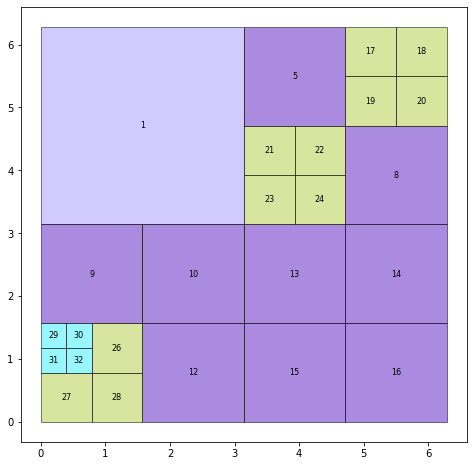

In [76]:
# 设置一维空间的取值范围
xmin = 0
xmax = 2*np.pi 
ymin = 0
ymax = 2*np.pi

# 定义Lid动态数组存储叶子单元格的网格编号
Lid = []

# 构建初始等距的四个网格单元
grid = []

leaf_id = 0
#construct_grid(grid, leaf_id, parent_id, xmin, xmax, ymin,ymax)
construct_grid(grid, leaf_id, 0, xmin, xmax / 2.0, ymax / 2.0, ymax)# construct_grid(grid, leaf_id, parent_id, xmin, xmax):
Lid.append(grid[-1].id)# 将新生成的叶子单元格加入到Lid数组中
construct_grid(grid, leaf_id, 0,  xmax / 2.0, xmax, ymax / 2.0, ymax)
Lid.append(grid[-1].id)
construct_grid(grid, leaf_id, 0,  xmin, xmax / 2.0, ymin ,ymax / 2.0)
Lid.append(grid[-1].id)
construct_grid(grid, leaf_id, 0, xmax / 2.0, xmax, ymin ,ymax / 2.0)
Lid.append(grid[-1].id)

# 对网格进行加密
plen = []
random_refinement_grid(Lid, grid, leaf_id, plen)


#更新叶子网格编号
update_leaf_id(Lid, grid)

visualize_2(grid,Lid)

In [10]:
print(len(plen))

7


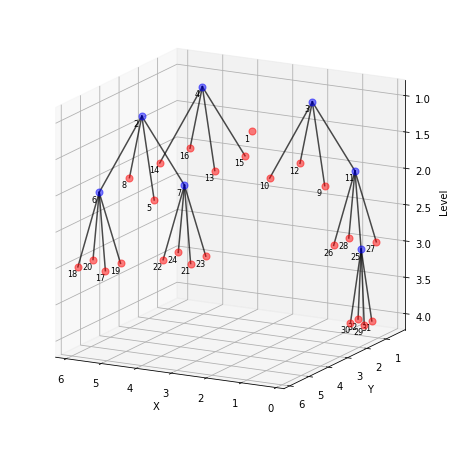

In [104]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_5(grid):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for cell in grid:
        color = "red" if cell.id in Lid else "blue"
        ax.scatter((cell.xmin + cell.xmax) / 2.0 ,(cell.ymin + cell.ymax) / 2.0,cell.lev, color=color, alpha=0.5, s=50)
        ax.text((cell.xmin + cell.xmax) / 2.0 + 0.1,  (cell.ymin + cell.ymax) / 2.0 + 0.1, cell.lev + 0.1,  str(cell.id), ha="center", va="center", fontsize=8)
        if cell.parent_id != 0:
            parent_cell = grid[cell.parent_id - 1]
            x = [(cell.xmin + cell.xmax) / 2.0, (parent_cell.xmin + parent_cell.xmax) / 2.0]
            y = [(cell.ymin + cell.ymax) / 2.0, (parent_cell.ymin + parent_cell.ymax) / 2.0]
            z = [cell.lev, parent_cell.lev]
            ax.plot(x, y, z, color="black", alpha=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Level')
    
    ax.invert_zaxis()
    # 设置视角
    ax.view_init(elev=15, azim=118)#elev 和 azim，分别表示仰角和方位角。
    # 设置背景颜色
    ax.set_facecolor('white')
    # 设置长宽高比
    ax.set_box_aspect([1, 1, 1])
    # 设置投影类型
    ax.set_proj_type('ortho')
    plt.show()
    
visualize_5(grid)